### Calculate VaR using Monte Carlo Simulation and Historical methods

In [1]:
import tushare as ts
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter("ignore")
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
# Identify the date range
start_date = '2015-12-31'
end_date = '2017-01-01'

In [3]:
# Retrieve data (for example: '000001', Chinese stock market)
stock_data = ts.get_k_data('000001', start_date, end_date)[['date','close']]
stock_data.set_index('date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)
stock_data.sort_index(inplace=True)
# convert single column dataframe to Series
stock_data = stock_data.squeeze()
stock_data.head()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


date
2015-12-31    8.799
2016-01-04    8.249
2016-01-05    8.308
2016-01-06    8.416
2016-01-07    7.924
Name: close, dtype: float64

In [4]:
# s_0: initial price use for Monte Carlo Simulation
s_0 = stock_data[-1]

# Calculate the daily returns
daily_returns = stock_data.pct_change()
daily_returns.dropna(inplace = True)

# Calculate the mean and standard deviation
mu_1 = daily_returns.mean()         
sigma_1 = daily_returns.std()

#### Historical Method to calculate VaR

In [7]:
VaR_1_hs = np.percentile(daily_returns, 1)
VaR_5_hs = np.percentile(daily_returns, 5)
VaR_10_hs = VaR_1_hs * np.sqrt(10)
print(f'1% VaR: {VaR_1_hs} \n5% VaR: {VaR_5_hs} \n10% VaR: {VaR_10_hs}')

1% VaR: -0.05550435723725071 
5% VaR: -0.022310011189742723 
10% VaR: -0.17552018893336305


#### Monte Carlo Simulation to calculate VaR

In [8]:
# Create a function to calculate the price for one step based on Geometric Brownian Motion
# Formula used: St = St-1 + St-1*[mu*dt + sigma*errorTerm*sqrt(dt)]

def GBM(s_0, mu, sigma, T ,n):
    """Calculate the price based on Geometric Brownian Motion
    
    parameters:
        s_0: initial price
        mu: mean returns during the date range
        sigma: standard deviation during the date range
        T: length of the forecasting period
        n: total steps for one simulation
    
    """
    delta_t = T/n
    
    simulated_price = [s_0]
    
    # Price Simulation
    for i in range(n):

        start_price = simulated_price[i]
        epsilon = np.random.normal()
        end_price = start_price + start_price * (mu*delta_t + sigma*epsilon*np.sqrt(delta_t))
        end_price = max(0, end_price) 
        simulated_price.append(end_price)
    
    return simulated_price

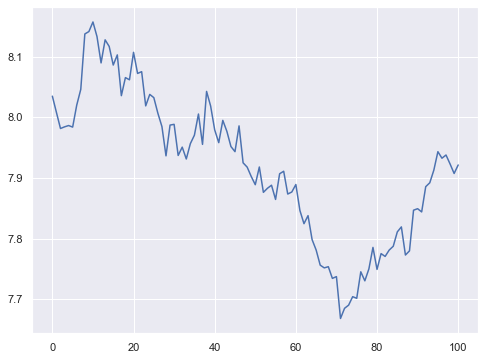

In [9]:
# Simulate the price after 10 days, total step is 100
sim1 = GBM(s_0, mu_1, sigma_1,10,100) 
sim1 = pd.Series(sim1) 
plt.figure(figsize=(8,6))
plt.plot(sim1)

In [10]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')
NCURVES = 300
curves = [GBM(s_0, mu_1, sigma_1,1,100) for i in range(NCURVES)]

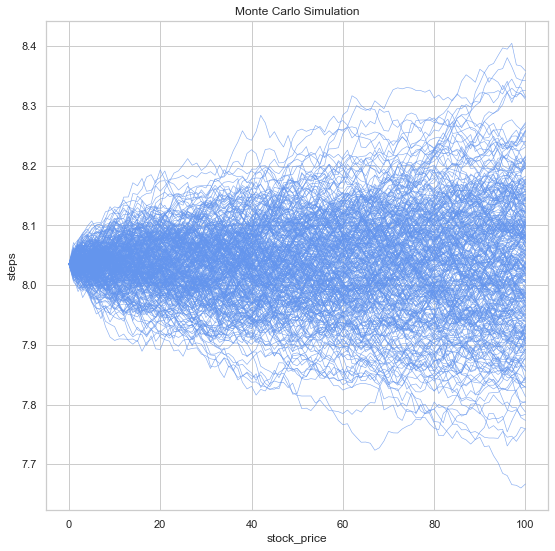

In [11]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
lines = []
for idx in range(len(curves)):
    line = curves[idx]
    retLine, = ax.plot(line,
                       color='cornflowerblue',
                       alpha=0.8,
                       linewidth=0.6)

plt.xlabel('stock_price', fontsize='large')
plt.ylabel('steps', fontsize='large')
plt.title('Monte Carlo Simulation', fontsize='large')
plt.show()

In [12]:
# Store 10000 simulation prices
simulated_prices_1 = []
for i in range(10000):
    simulated_price = GBM(s_0, mu_1, sigma_1, 1,100)
    final_price = simulated_price[-1]
    simulated_prices_1.append(final_price)

In [13]:
simulated_return_1 = simulated_prices_1/s_0-1      
simulated_return_1

array([ 0.01031961,  0.02782455, -0.00365363, ...,  0.00794252,
        0.05065979,  0.00186364])

In [14]:
# Calculate the VaR
VaR_1 = np.percentile(simulated_return_1, 1)
VaR_5 = np.percentile(simulated_return_1, 5)
VaR_10 =  VaR_1 * np.sqrt(10)
print(f'1% VaR: {VaR_1} \n5% VaR: {VaR_5} \n10% VaR: {VaR_10}')

1% VaR: -0.033584072076346824 
5% VaR: -0.023428105568982276 
10% VaR: -0.10620216086451624
